In [1]:
from datetime import date
import datetime 
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats

#Module 1 - Get data
def getStockData(ticker):
    df = pd.DataFrame()
    today = date.today()
    current_day = int(today.strftime('%d'))
    current_month = int(today.strftime('%m'))
    current_year = int('20'+today.strftime('%y'))
    start = datetime.date(2021,8,15)
    end = datetime.date(current_year,current_month,current_day)
    companies_list=[ticker]
    stock = yf.download(ticker, start=start, end=end, progress=False)
    df = df.append(stock, sort=False)
    df['Ticker'] = ticker
    return df
#df = getStockData(stock = 'TSLA')

# def move_download(TICKER):
#     source = f'C:/Users/joaom/Downloads/{TICKER}.csv'
#     destination = 'C:/Users/joaom/OneDrive/Documentos/GitHub/Snp1000/Performance Tables'
#     dest = shutil.move(source, destination) 

#Module 2 - Calculate RSI (relative Strength Index)
#df = df.iloc[-60:] # Get just about the last two months of data
def calculateRSI(df):
    df.reset_index(inplace=True)
    df['Change'] = (df['Close'].shift(-1)-df['Close']).shift(1)
    df['ChangeAverage'] = df['Change'].rolling(window=2).mean()
    df['ChangeAverage+'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] > 0 else 0,axis=1).rolling(window=14).mean()
    df['ChangeAverage-'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] < 0 else 0,axis=1).rolling(window=14).mean()*-1
    df['RSI'] = 100-(100/(1+(df['ChangeAverage+']/df['ChangeAverage-'])))
    df = df.drop(columns = ['ChangeAverage','ChangeAverage','ChangeAverage'])
    return df

#Module 3 - Calculate OBV (On Balance Volume) 
def calculateOBV(df):
    VolumeList = df['Volume'].tolist()
    OBV = [VolumeList[0]]
    i=1
    for i in range(1,len(VolumeList)):
        #i=i+1
        if VolumeList[i] > VolumeList[i-1]:
            OBV.append(OBV[i-1]+VolumeList[i])
            continue
        if VolumeList[i]==VolumeList[i-1]:
            OBV.append(OBV[i-1]+0)
            continue
        if VolumeList[i]<VolumeList[i-1]:
            OBV.append(OBV[i-1]-VolumeList[i])
            continue  
    df['OBV'] = OBV
    return df


#Module 4 - Calculate Linear Regressions on OBV plus errors
def calculateLrObv(df,delay):
    OBV = df['Date']
    Date = df['Date'].tolist()
    OBV_regression = [0 for x in range(delay)]
    OBV_regression_err = [0 for x in range(delay)]
    x = np.array([x for x in range(delay)])
    for i in range(delay,len(OBV)):
        y = df['OBV'].iloc[i-delay:i].values
        slope, intercept, r_value, p_value, err = stats.linregress(x,y)
        OBV_regression.append(slope)
        OBV_regression_err.append(err)
    df['OBV_regression']  = OBV_regression
    df['OBV_regression'] = 100*(df['OBV_regression'])/max(df['OBV_regression'])
    df['OBV_Regression_err'] = OBV_regression_err
    return df


#Module 5 - Calculate Linear Regressions on Close plus errors

# Calculating Close trends
def calculateLrClose(df,delay):
    OBV = df['OBV']
    Date = df['Date'].tolist()
    delay=15 # How many trading days to calculate moving slopes
    Close_regression = [0 for x in range(delay)]
    Close_regression_err = [0 for x in range(delay)]
    x = np.array([x for x in range(delay)])
    for i in range(delay,len(OBV)):
        y2 = df['Close'].iloc[i-delay:i].values
        slope2, intercept2, r_value2, p_value2, err2 = stats.linregress(x,y2)
        Close_regression.append(slope2)
        Close_regression_err.append(err2)
    df['Close_Regression'] = Close_regression
    df['Close_Regression_err'] = Close_regression_err
    return df


#Module 6 - Calculate Moving Average Convergence Divergence
def calculateMACD(df):
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    return df



def returnFinalDf(df):
    df = df.drop([], axis  = 1) # 'OBV_Regression_err','Close_Regression_err'
    return df

def pipeline(Stocks): # Received a list of stock tickers, ie ['TSLA','AAPL','SNOW']
    outputDataframe = pd.DataFrame()
    for TICKER in Stocks:
        df = getStockData(ticker = TICKER)
        df = calculateRSI(df)
        df = calculateOBV(df)
        df = calculateLrObv(df,delay = 5)  
        df = calculateLrClose(df,delay = 15)
        df = calculateMACD(df)
        df = returnFinalDf(df)
        outputDataframe = outputDataframe.append(df)
        outputDataframe.reset_index(drop=True, inplace=True)


    #Export to Excel (clean excel sheet initially to always paste correctly)
    filename_csv = 'PowerBi/stocks.csv'
    outputDataframe.to_csv(filename_csv)
    print('DataFrame is written successfully to CSV Sheet.')
    return outputDataframe

df = pipeline(['TSLA','AAPL','MSFT','NVDA','V','ARVL','DIS','NFLX','PFE','CCL','XPEV','SE'])


In [2]:
# def pipeline(Stocks): # Received a list of stock tickers, ie ['TSLA','AAPL','SNOW']
#     outputDataframe = pd.DataFrame()
#     for TICKER in Stocks:
#         df = getStockData(ticker = TICKER)
#         df = calculateRSI(df)
#         df = calculateOBV(df)
#         df = calculateLrObv(df,delay = 5)  
#         df = calculateLrClose(df,delay = 15)
#         df = calculateMACD(df)
#         df = returnFinalDf(df)
#         outputDataframe = outputDataframe.append(df)
#         outputDataframe.reset_index(drop=True, inplace=True)


#     #Export to Excel (clean excel sheet initially to always paste correctly)
#     filename_csv = 'PowerBi/stocks.csv'
#     outputDataframe.to_csv(filename_csv)
#     print('DataFrame is written successfully to CSV Sheet.')
#     return outputDataframe

# df = pipeline(['TSLA','AAPL','MSFT','NVDA','V','ARVL','DIS','NFLX','PFE','CCL','XPEV','SE'])


DataFrame is written successfully to CSV Sheet.


In [4]:
# from matplotlib.dates import DateFormatter

# fig, axs = plt.subplots(7)
# fig.suptitle('Vertically stacked subplots')

# axs[0].plot(df['Date'], df['Close'])
# axs[1].plot(df['Date'], df['OBV_Regression'])
# axs[2].plot(df['Date'], df['OBV'])
# axs[3].plot(df['Date'], df['RSI'])
# axs[4].plot(df['Date'], df['MACD'])
# axs[5].plot(df['Date'], df['EMA26'])
# axs[6].plot(df['Date'], df['EMA12'])


# fig.autofmt_xdate()
# plt.show()

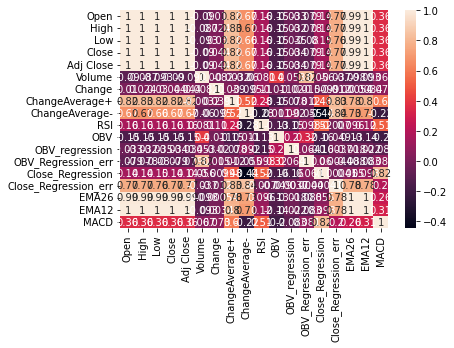

In [7]:
# data = tesla[['Date','RSI']]
# dataOBV = tesla[['','OBV']]

# correlation = data.corr(method='pearson')
# correlationOBV = dataOBV.corr(method='pearson')

# print(correlation)
# print(correlationOBV)

import seaborn as sn
import matplotlib.pyplot as plt


corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()